## Imports

In [1]:
import ast
import math

import requests
import urllib
import time

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from ast import literal_eval
from scipy import stats

## Definitions of constants

These are the constants for the data paths.

In [2]:
DATA_FOLDER           = "../data/"
PROCESSED_DATA_FOLDER = '../processed_data/'
CORENLP_DATA_FOLDER   = '../corenlp_plot_summaries/'

CHARACTER_DATASET     = DATA_FOLDER + "character.metadata.tsv"
MOVIE_DATASET         = DATA_FOLDER + "movie.metadata.tsv"
NAME_CLUSTER_DATASET  = DATA_FOLDER + "name.clusters.txt"
PLOT_DATASET          = DATA_FOLDER + "plot_summaries.txt"
TVTROPES_DATASET      = DATA_FOLDER + "tvtropes.clusters.txt"

PROCESSED_CHARACTER   = PROCESSED_DATA_FOLDER + 'character_metadata.csv'
PROCESSED_MOVIE       = PROCESSED_DATA_FOLDER + 'movie_metadata.csv'
PROCESSED_NAME        = PROCESSED_DATA_FOLDER + 'name_clusters.csv'
PROCESSED_PLOT        = PROCESSED_DATA_FOLDER + 'plot_summaries.csv'
PROCESSED_TVTROPES    = PROCESSED_DATA_FOLDER + 'tvtropes_clusters.csv'

# Step 1

### 1.1 Pre-processing the data

At first, we fetch the data from the `data` folder into pd dataframes in order to set the desired headings and to modify the type if needed.
Then we store it in `processed_data` folder in the desired .csv format.

For `movie_metadata` and `character_metadata` we modify the dates to the datetime format.

In [3]:
movie_metadata = pd.read_csv(MOVIE_DATASET, sep='\t', header=None) \
    .rename(columns={0 : 'wikipedia_movie_id',
                     1 : 'freebase_movie_id',
                     2 : 'movie_name',
                     3 : 'movie_release_date',
                     4 : 'office_revenue',
                     5 : 'runtime',
                     6 : 'languages',
                     7 : 'countries',
                     8 : 'genres'})

movie_metadata['movie_release_date'] = pd.to_datetime(movie_metadata['movie_release_date'], errors = 'coerce')
movie_metadata['movie_release_year'] = movie_metadata['movie_release_date'].apply(lambda d : d.year)

In [4]:
character_metadata = pd.read_csv(CHARACTER_DATASET, sep='\t', header=None) \
    .rename(columns={0  : 'wikipedia_movie_id',
                     1  : 'freebase_movie_id',
                     2  : 'movie_release_date',
                     3  : 'character_name',
                     4  : 'actor_birth_date',
                     5  : 'actor_gender',
                     6  : 'actor_height',
                     7  : 'actor_ethnicity',
                     8  : 'actor_name',
                     9  : 'actor_age',
                     10 : 'freebase_map_id',
                     11 : 'freebase_character_id',
                     12 : 'freebase_actor_id'})

character_metadata['movie_release_date'] = pd.to_datetime(character_metadata['movie_release_date'],          errors='coerce')
character_metadata['actor_birth_date'] =   pd.to_datetime(character_metadata['actor_birth_date'], utc=True , errors='coerce')

In [5]:
plot_summaries = pd.read_csv(PLOT_DATASET, sep='\t', header=None)\
    .rename(columns={0 : 'movie_id',
                     1 : 'plot'})

In [6]:
name_clusters = pd.read_csv(NAME_CLUSTER_DATASET, sep='\t', header=None)\
    .rename(columns={0 : 'character_name',
                     1 : 'freebase_map_id'})

For the `tvtropes_cluster` : we first create a raw dataframe containing the data.
Then we construct the resulting dataframe where each values of the dictionary correspond to the correct column.

In [7]:
tvtropes_cluster_raw = pd.read_csv(TVTROPES_DATASET, sep='\t', header=None)
tvtropes_cluster_raw[1] = tvtropes_cluster_raw[1].map(ast.literal_eval)
tvtropes_cluster = pd.DataFrame()

tvtropes_cluster['character_type'] = tvtropes_cluster_raw[0]
tvtropes_cluster['character_name'] = tvtropes_cluster_raw[1].map(lambda d : d['char'])
tvtropes_cluster['movie_name']     = tvtropes_cluster_raw[1].map(lambda d : d['movie'])
tvtropes_cluster['movie_id']       = tvtropes_cluster_raw[1].map(lambda d : d['id'])
tvtropes_cluster['actor_name']     = tvtropes_cluster_raw[1].map(lambda d : d['actor'])

Storing the cleaned data

In [8]:
character_metadata.to_csv(PROCESSED_CHARACTER, index=False)
movie_metadata    .to_csv(PROCESSED_MOVIE,     index=False)
plot_summaries    .to_csv(PROCESSED_PLOT,      index=False)
name_clusters     .to_csv(PROCESSED_NAME,      index=False)
tvtropes_cluster  .to_csv(PROCESSED_TVTROPES,  index=False)

### 1.2 Creating the datasets

In [9]:
#calculate the ratio of female actors for each movie

movie_gender = character_metadata.groupby(['wikipedia_movie_id', 'actor_gender']).size().unstack(fill_value=0)
movie_gender['women_ratio'] = movie_gender['F'] / (movie_gender['M'] + movie_gender['F'])
#TODO maybe interesting to also have the total number of actors for each movies
movie_gender = movie_gender['women_ratio'].reset_index()

Gender parity datasets

In [10]:
movie_information = ['wikipedia_movie_id', 'movie_release_date', 'movie_release_year', 'movie_name', 'office_revenue', 'countries', 'genres']
gender_parity = pd.merge(movie_gender, movie_metadata[movie_information], on='wikipedia_movie_id').dropna()

Movie genre dataset

In [11]:
movie_genre_information = ['wikipedia_movie_id', 'movie_release_date', 'movie_name','genres']

movie_genre = pd.merge(movie_metadata[movie_genre_information].rename(columns={'wikipedia_movie_id' : 'movie_id'}), \
    plot_summaries, on='movie_id', how='inner').dropna()

#we are interested in the year only
movie_genre['year'] = pd.DatetimeIndex(movie_genre['movie_release_date']).year.astype('int')
movie_genre = movie_genre.drop(columns=['movie_release_date'])

#we convert the values of the genres dictionnaries to list
movie_genre['genres'] = movie_genre['genres'].apply(ast.literal_eval).apply(lambda x : set(x.values()))

# Step 2

Create the subsets to properly make some observations

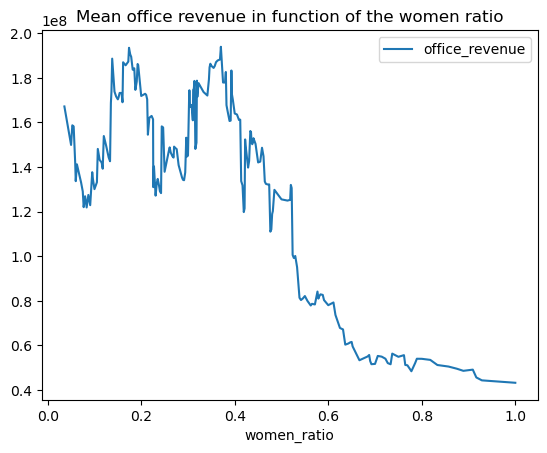

In [12]:
#first by office revenue
movie_gender_office_revenue = gender_parity[['women_ratio','office_revenue']].\
    groupby('women_ratio')\
    .agg({'office_revenue' : 'mean'})

#make a mean by rolling windows to smooth up the function
movie_gender_office_revenue = movie_gender_office_revenue.rolling(window=30, min_periods=1, center=False).mean()
movie_gender_office_revenue = movie_gender_office_revenue.iloc[2:].reset_index()

#now we can plot a graph
movie_gender_office_revenue.plot(x='women_ratio', y='office_revenue', title="Mean office revenue in function of the women ratio") ;


Auxiliary function to make a subset from a column where values are dictionaries

In [177]:
def bootstrap_ci(data, ci=0.95):
    if len(set(data)) > 1 :
        bootstrap_res = stats.bootstrap((data,), np.mean, confidence_level=ci)
        return bootstrap_res.confidence_interval
    else :
        return np.nan

In [178]:
def deconstruct_dict(df, col_name):
    df[col_name] = df[col_name] \
        .apply(ast.literal_eval).apply(lambda x : list(x.values()))
    df = df.apply(pd.Series.explode)\
        .reset_index().drop(columns=['index'])
    return df

In [179]:
def make_subset_gender_parity(col_name, gender_parity_df = gender_parity) :
    subset = gender_parity_df[['women_ratio','wikipedia_movie_id', col_name]].copy()

    #change the dict to list of values and explode them to get one value per row
    subset = deconstruct_dict(subset, col_name)

    #group by the desired column and make the mean of the women ratios
    subset = subset.groupby(col_name)\
        .agg({'women_ratio' : ['mean', bootstrap_ci], 'wikipedia_movie_id' : 'count'})\
        .sort_values(by=[('women_ratio', 'mean')])

    subset.columns = ['_'.join(col) for col in subset.columns.values]

    return subset.reset_index()

Plot the movie_gender per country on a world heat map.

In [180]:
#make the subset by country
movie_gender_country = make_subset_gender_parity('countries')

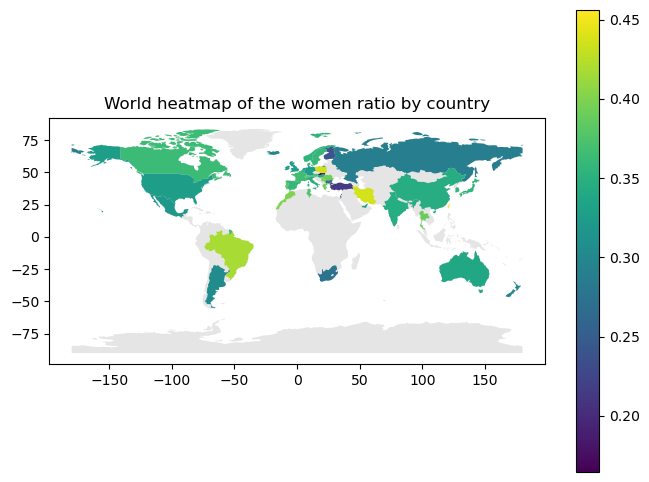

In [181]:
#get the world countries
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
plt.title("World heatmap of the women ratio by country")

#plot the countries in light gray
countries.plot(color="k", alpha=0.1, ax=ax)

#add the color in function of the women ratio
df = countries.merge(movie_gender_country.loc[movie_gender_country['wikipedia_movie_id_count'] > 2]
                     .rename(columns={'countries' : 'name'}), on='name', how='inner')
gpd.GeoDataFrame(df).plot(column='women_ratio_mean',ax=ax, legend=True) ;

Plot the women ratio by movie genres

In [182]:
genres = {"Action" : {"war", "military", "action", "spy", "espionage", "combat", "martial", "prison", "anti-war", "escape", "gangster", "escape", "heist", "epic"},
          "Comedy" : {"comedy", "fun", "parody"},
          "Horror" : {"horreur", "scary", "zombie"}, 
          "Science fiction" : {"space", "time", "science", "robot", "disaster", "apocalypse", "alien", "monster", "sci-fi", "fiction"},
          "Western" : {"western", "cowboy", "anti-western"},
          "Romance" : {"romance"},
          "Documentary" : {"society", "culture", "sport", "empire", "documentary", "sports"},
          "Thriller" : {"thriller", "spy", "conspiracy"},
          "Fantasy" : {"bangsian", "fantasy", "dark", "fables", "magic", "myth", "legends", "sorcery"},
          "Historical" : {"historical", "period", "history", "counterfactual"},
          "Crime" : {"detective", "crime", "murder", "mysteries", "enquete", "thief"},
          "Drama" : {"docudrama", "drama", "teen", "political", "melodrama", "issues"},
          "Animation" : {"animation", "motion", "stop", "claymation", "animated", "puppetry"},
          "Pornographic" : {"sex", "pornographic", "sexploitation", "erotica", "adult"}}

def regroup_genre(elements):
    for k,v in genres.items() :
        if len(elements.intersection(v)) :
            return k
    return pd.NaT

## A. what is the gender parity across movie genres (are westerns still as male dominated as the stereotype describes it?)

In [183]:
average_ratio = np.average(gender_parity['women_ratio'])

In [184]:
def test_overlap(before_ci, after_ci):
    cond1 = before_ci[0] < after_ci[0]  < before_ci[1]
    cond2 = before_ci[0] < after_ci[1]  < before_ci[1]
    cond3 = after_ci[0]  < before_ci[1] < after_ci[1]
    cond4 = after_ci[0]  < before_ci[1] < after_ci[1]
    return cond1 or cond2 or cond3 or cond4

In [185]:
def split_gender_parity(treshold_year):
    before = gender_parity[gender_parity.movie_release_year <= treshold_year]
    after  = gender_parity[gender_parity.movie_release_year >  treshold_year]
    return before, after

In [186]:
def split_and_filter(treshold_year, min_count, col_name):
    gender_parity_before, gender_parity_after = split_gender_parity(treshold_year)

    before = make_subset_gender_parity(col_name, gender_parity_before)
    after  = make_subset_gender_parity(col_name, gender_parity_after )

    merged = before.merge(after, on=col_name, suffixes=('_before', '_after'))

    merged_filtered = merged[merged.wikipedia_movie_id_count_after + merged.wikipedia_movie_id_count_before > min_count]

    return merged_filtered

In [187]:
def plot_ratio_by_categories(subset, col_name, min_count=100):
    filtered_subset = subset[subset.wikipedia_movie_id_count > min_count].dropna()

    plt.figure(figsize=(6, len(filtered_subset) * 0.2))
    for i, col in enumerate(filtered_subset[['women_ratio_mean', 'women_ratio_bootstrap_ci']].iloc):
        plt.plot(col['women_ratio_bootstrap_ci'], (i,i),'-|k')
        plt.plot(col['women_ratio_mean'], i, '.r')

    plt.yticks(range(len(filtered_subset)),list(filtered_subset[col_name]))
    plt.vlines(average_ratio, 0, len(filtered_subset), linestyle = '--')

    plt.title('Ratio of women by ' + col_name + ' with 95% confidence intervals')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [188]:
def plot_evolution(col_name, treshold_year, min_count=100):
    merged_filtered = split_and_filter(treshold_year, min_count, col_name).dropna()

    plt.figure(figsize=(6, len(merged_filtered) * 0.2))

    for y, col in enumerate(merged_filtered.iloc):
        plt.plot(col['women_ratio_bootstrap_ci_before'], (y,y),'-|b')
        plt.plot(col['women_ratio_mean_before'], y, '.b')
        plt.plot(col['women_ratio_bootstrap_ci_after'], (y,y),'-|g')
        plt.plot(col['women_ratio_mean_after'], y, '.b')

    plt.yticks(range(len(merged_filtered)),list(merged_filtered[col_name]))
    plt.vlines(average_ratio, 0, len(merged_filtered), linestyle = '--')

    plt.title('evolution (before/after ' + str(treshold_year) + ' ) of ratio by ' + col_name + ' with 95% confidence intervals')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [189]:
def plot_evolution_arrow(col_name, treshold_year, min_count=100):
    merged_filtered = split_and_filter(treshold_year, min_count, col_name).dropna()

    plt.figure(figsize=(6, len(merged_filtered) * 0.2))

    for y, col in enumerate(merged_filtered.iloc):
        ratio_before = col['women_ratio_mean_before']
        ratio_after  = col['women_ratio_mean_after' ]
        dx = ratio_after - ratio_before
        plt.plot(col['women_ratio_mean_before'], y, '.r')
        overlap = test_overlap(col['women_ratio_bootstrap_ci_before'], col['women_ratio_bootstrap_ci_after'])
        plt.arrow(ratio_before, y, dx, 0,
                  head_width = 0.7,
                  head_length = 0.005,
                  ec = 'black' if overlap else 'red')

    plt.yticks(range(len(merged_filtered)),list(merged_filtered[col_name]))
    plt.vlines(average_ratio, 0, len(merged_filtered), linestyle = '--')

    plt.title('evolution (before/after ' + str(treshold_year) + ' ) of ratio by ' + col_name + ' as arrows')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [190]:
def plot_by_year(col_name, attribute):
    df = deconstruct_dict(gender_parity.copy(), col_name)
    df[df[col_name] == attribute][['movie_release_year', 'women_ratio']].groupby('movie_release_year').agg('mean').plot()
    plt.title('ratio by year in ' + attribute)
    plt.ylabel('ratio')
    plt.xlabel('year')

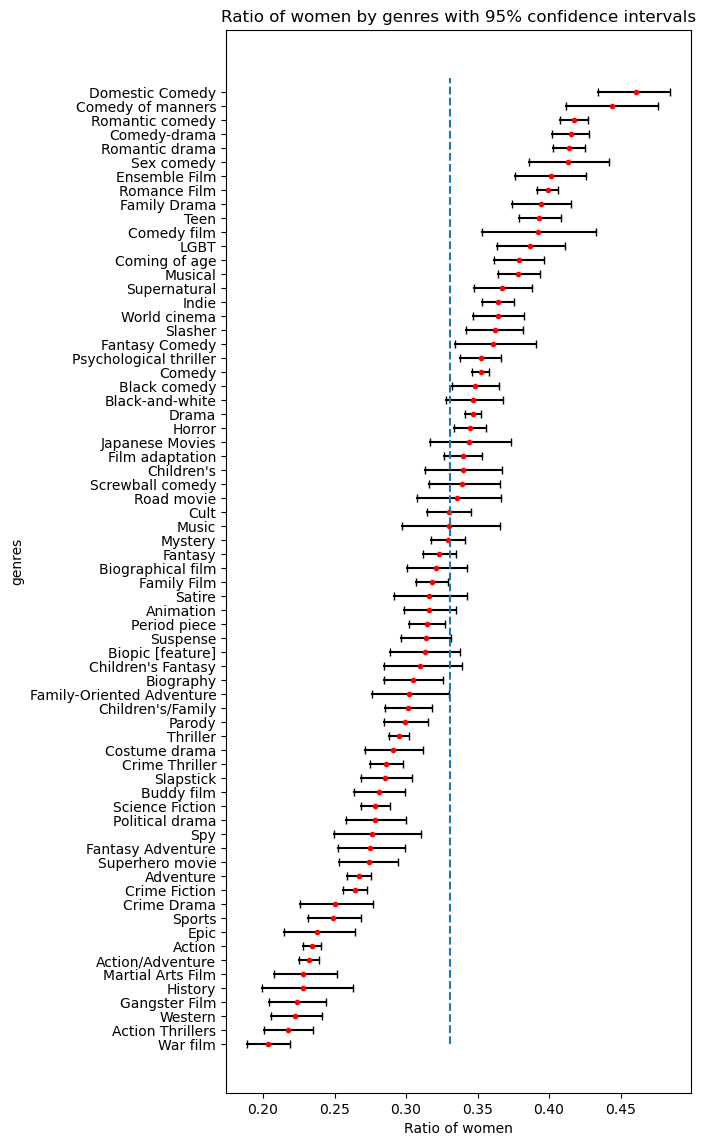

In [192]:
movie_gender_genre = make_subset_gender_parity('genres')
plot_ratio_by_categories(movie_gender_genre, 'genres', min_count=100)

Above we can clearly see that movie genre is significantly impacting gender ratio.
Indeed, average ratio is out of confident intervals for many movies genres.

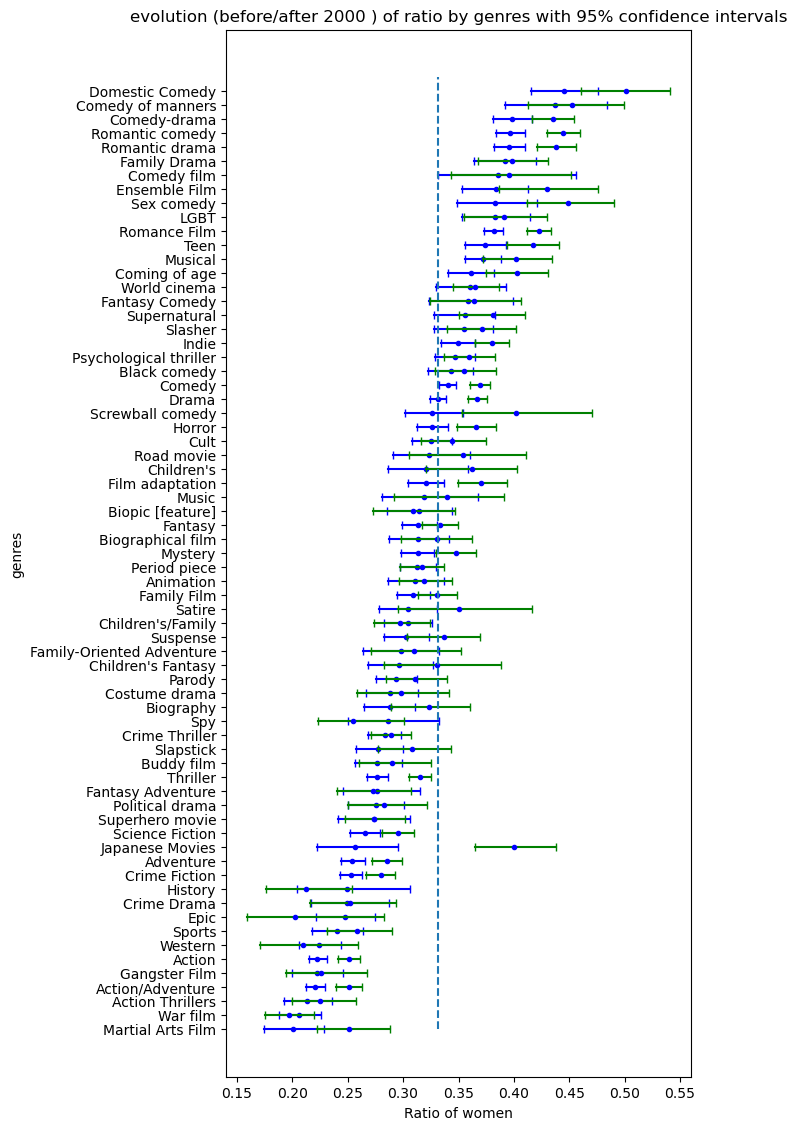

In [28]:
plot_evolution('genres', 2000, min_count=100)

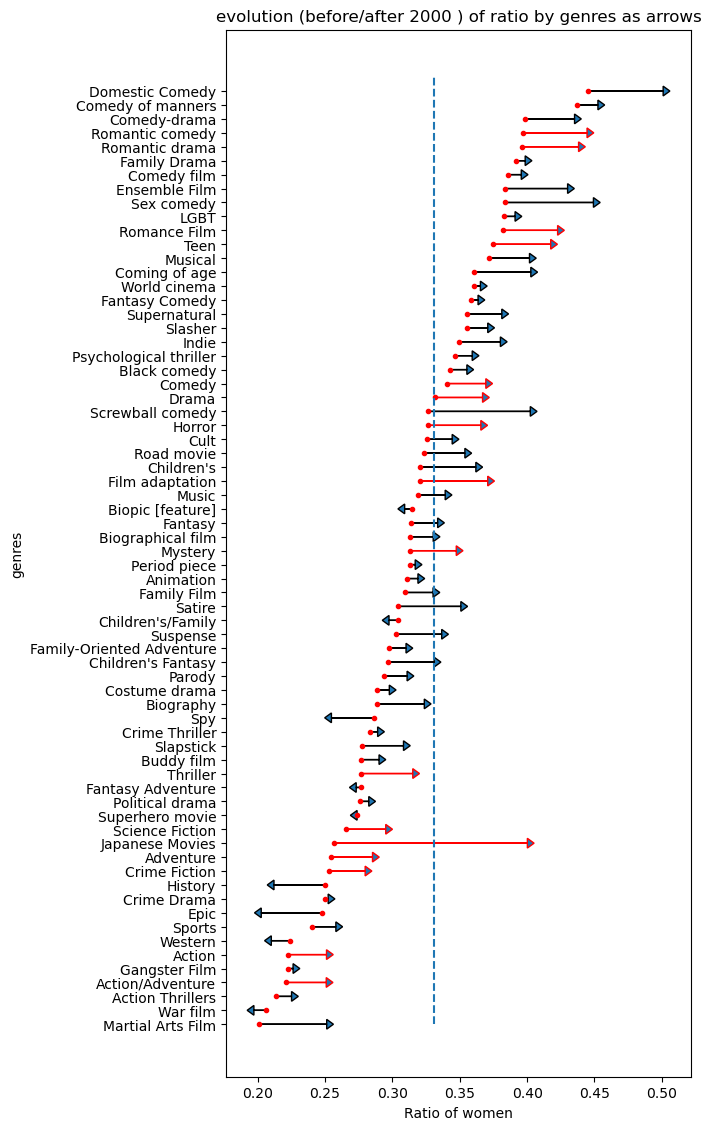

In [29]:
plot_evolution_arrow('genres', 2000, min_count=100)

Above we can see the evolution showed by arrows. Only red arrows show evolution statistically significant under $\alpha = 0.05$

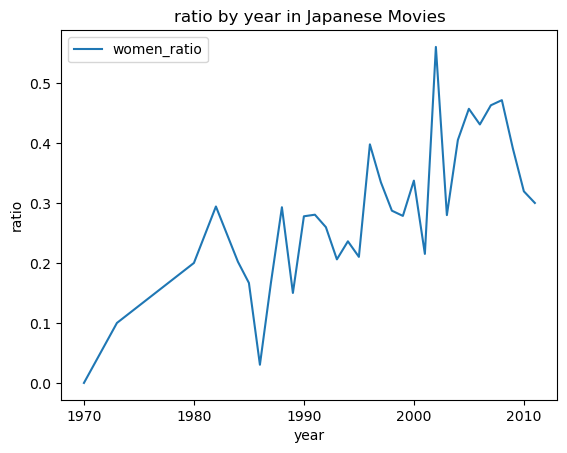

In [30]:
plot_by_year('genres', 'Japanese Movies')

## B. what is the evolution of gender parity in films among countries over time (were some countries avant-garde? Are some still behind on this concept?)

`countries_metadata.csv` key points :
- `hdi_year` : human developement index of the contry by year
- `gii_year` : gender inequality index

In [37]:
# source : https://hdr.undp.org/data-center/documentation-and-downloads
countries_metadata = pd.read_csv(DATA_FOLDER + 'countries_metadata.csv')

In [38]:
translate_countries = {
    'United States of America' : 'United States',
    'Hong Kong'                : 'Hong Kong, China (SAR)',
    'South Korea'              : 'Korea (Republic of)',
    'Korea'                    : 'Korea (Republic of)',
    'Russia'                   : 'Russian Federation',
    'England'                  : 'United Kingdom',
    'Scotland'                 : 'United Kingdom',
    'Kingdom of Great Britain' : 'United Kingdom',
    'Czech Republic'           :'Czechia',
    'Iran'                     : 'Iran (Islamic Republic of)',
    'Vietnam'                  : 'Viet Nam',
    'Slovak Republic'          : 'Slovakia'
}

In [43]:
metadata_cols = np.array(countries_metadata.columns)

In [123]:
indicators = []
for indicator in metadata_cols:
    if '2000' in indicator:
        indicators.append(indicator[:-5])

In [124]:
def create_df_country_year(year):
    col_year = [indicator + '_' + str(year) for indicator in indicators]
    df = pd.DataFrame()
    df['year'] = 0
    df[['country'] + indicators] = countries_metadata[['country'] + col_year]
    df['year'] = year
    return df

In [125]:
countries_metadata_by_year = pd.DataFrame()

for year in range(1990, 2013):
    df_country_year = create_df_country_year(year)
    countries_metadata_by_year = pd.concat([countries_metadata_by_year, df_country_year])

In [603]:
parity_with_index = gender_parity[['wikipedia_movie_id','women_ratio', 'movie_release_year', 'countries']].copy()
parity_by_hdi = deconstruct_dict(parity_by_hdi, 'countries').dropna()
parity_by_hdi['country_year'] = list(zip(parity_by_hdi.countries, parity_by_hdi.movie_release_year))
parity_by_hdi['hdi'] = parity_by_hdi['country_year'].apply(lambda x : find_index(x[0], x[1], index_name = 'hdi'))
parity_by_hdi = parity_by_hdi.dropna()

In [236]:
countries_metadata_by_year

,year,country,hdi,le,eys,mys,gnipc,gdi,hdi_f,le_f,...,se_f,se_m,pr_f,pr_m,lfpr_f,lfpr_m,phdi,diff_hdi_phdi,co2_prod,mf
0,1990,Afghanistan,0.273,45.967200,2.504050,0.971125,2684.550019,0.595,0.196280,48.397300,...,0.700485,5.419459,NaN,NaN,15.180000,77.430000,0.270,1.098901,0.209727,2.330000
1,1990,Angola,NaN,41.893300,3.537480,NaN,4845.706901,NaN,NaN,45.453200,...,4.495717,23.282538,9.545455,90.454545,75.408000,79.292000,NaN,NaN,0.429586,2.440000
2,1990,Albania,0.647,73.143900,11.602930,7.354632,4742.215529,0.922,0.616864,76.433400,...,58.164883,67.010643,NaN,NaN,51.364000,72.510000,0.619,4.327666,1.656902,6.630000
3,1990,Andorra,NaN,78.406300,10.798780,NaN,43773.146500,NaN,NaN,82.675600,...,NaN,NaN,7.142857,92.857143,NaN,NaN,NaN,NaN,7.461153,NaN
4,1990,United Arab Emirates,0.728,71.900400,10.474560,5.759906,102433.136000,0.961,0.697888,74.921900,...,43.907296,42.276174,0.000000,100.000000,29.083000,91.714000,0.359,50.686813,28.277672,64.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2012,Europe and Central Asia,0.760,72.606274,13.711788,10.012632,15161.409430,0.957,0.740477,76.194267,...,77.771789,85.072341,18.042414,81.957586,44.256429,67.756511,0.683,10.131579,5.586801,13.107171
202,2012,Latin America and the Caribbean,0.744,74.067656,13.809491,8.107920,15182.341940,0.976,0.733222,77.213909,...,55.489163,56.288524,24.388753,75.611247,50.370855,76.619330,0.679,8.736559,3.034836,14.114108
203,2012,South Asia,0.596,67.915940,10.919139,5.679543,4741.289840,0.827,0.526163,69.837316,...,31.163095,48.164825,18.153365,81.846635,24.282073,77.972458,0.576,3.355705,1.598469,4.699407
204,2012,Sub-Saharan Africa,0.516,57.987394,9.546207,5.120678,3551.647275,0.888,0.484847,59.584516,...,26.191204,38.290734,20.634746,79.365254,63.996598,74.062532,0.504,2.325581,0.872779,3.437760


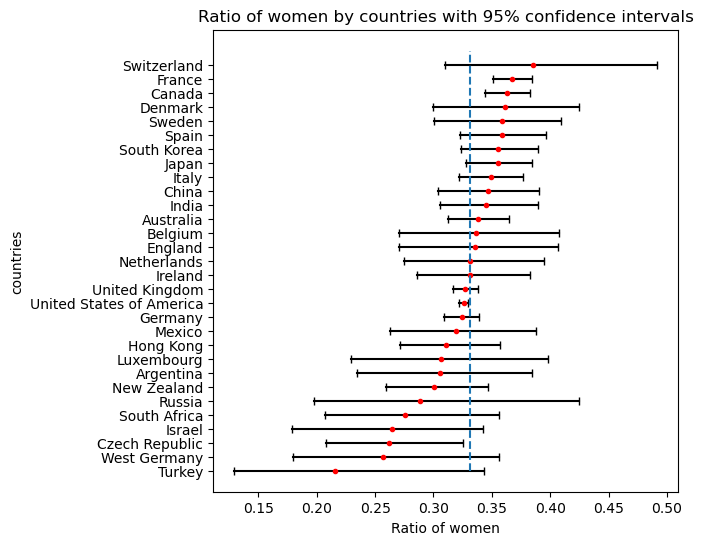

In [31]:
movie_gender_country = make_subset_gender_parity('countries')
plot_ratio_by_categories(movie_gender_country, 'countries', min_count=15)

Above we cannot observe significant impact of country on the gender ratio.
Indeed, average ratio is inside of confident intervals for many countries.

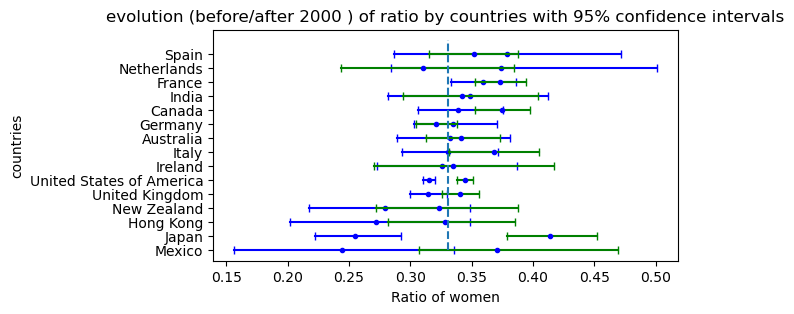

In [32]:
plot_evolution('countries', 2000, min_count=20)

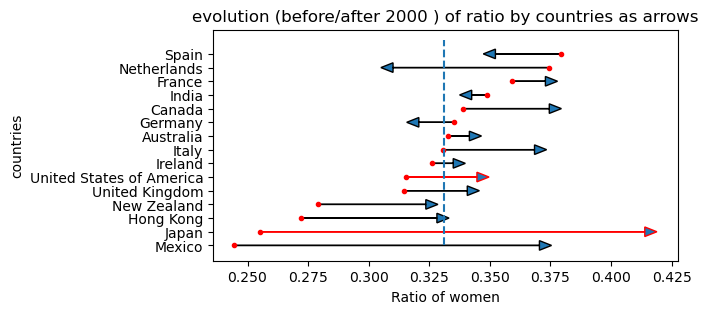

In [33]:
plot_evolution_arrow('countries', 2000, min_count=20)

Above we can see the evolution showed by arrows. Only red arrows show evolution statistically significant under $\alpha = 0.05$

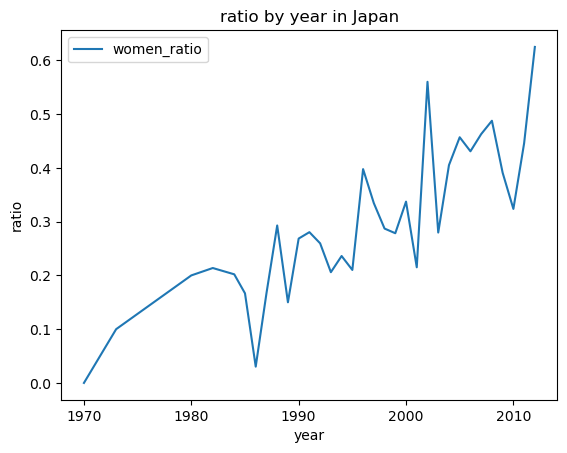

In [34]:
plot_by_year('countries', 'Japan')

## D. Is there a variation of the main attributes -agent verbs, patient verbs and attributes- given to each gender across time?

In [243]:
def importance_word(x, word):
    y = list(np.hstack(x))
    l = len(y)
    return 0 if l==0 else y.count(word)/len(y)

In [244]:
movie_nlp = pd.read_csv(PROCESSED_DATA_FOLDER + 'movie_nlp.csv', index_col='movie_id', dtype={'movie_id' : int},
                            converters={'actions by men'      : literal_eval, 'actions by women'      : literal_eval,
                                        'actions on men'      : literal_eval, 'actions on women'      : literal_eval,
                                        'descriptions of men' : literal_eval, 'descriptions of women' : literal_eval})

In [245]:
nlp_descriptions = ['actions by men', 'actions by women', 'actions on men', 'actions on women', 'descriptions of men', 'descriptions of women']
nlp_number_descriptions = ['number of ' + d for d in nlp_descriptions]
actions = ['actions by men', 'actions by women', 'actions on men', 'actions on women']

In [246]:
for i in range(6):
    movie_nlp[nlp_number_descriptions[i]] = movie_nlp[nlp_descriptions[i]].apply(len)

In [247]:
for desc in nlp_descriptions:
    movie_nlp[desc + ' unique'] = movie_nlp[desc].apply(np.unique)

In [248]:
movie_metadata_nlp = movie_metadata[['wikipedia_movie_id', 'movie_release_year']].dropna()\
    .merge(movie_nlp, left_on='wikipedia_movie_id', right_on='movie_id')

In [249]:
movie_metadata_nlp['decade_released'] = movie_metadata_nlp['movie_release_year'].apply(lambda year : math.floor(year/10) * 10)

In [250]:
movie_metadata_nlp = movie_metadata_nlp.set_index('wikipedia_movie_id')

#### Plotting results

In [251]:
b = pd.DataFrame(movie_metadata_nlp[['decade_released'] + nlp_number_descriptions].groupby('decade_released').agg(np.sum))

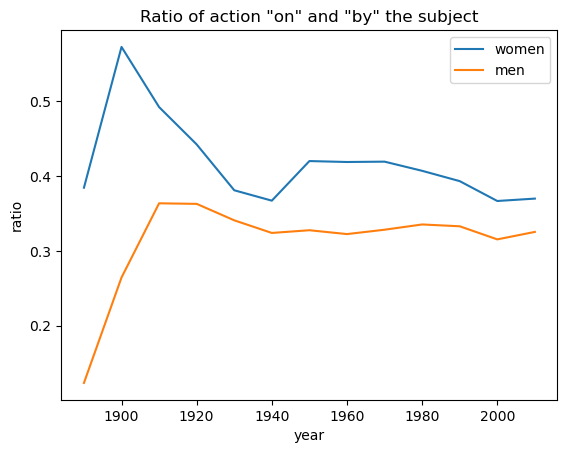

In [252]:
plt.plot((b['number of actions on women'] / b['number of actions by women']), label = 'women')
plt.plot((b['number of actions on men'  ] / b['number of actions by men'  ]), label = 'men')
plt.legend(loc="upper right")
plt.title('Ratio of action "on" and "by" the subject')
plt.xlabel('year')
plt.ylabel('ratio');

We can see above that women then to be more often the object than the subject compared to men.
Women seems to be more passive than men

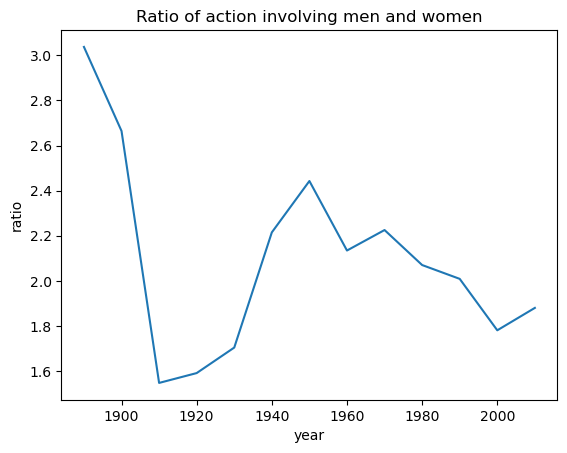

In [253]:
((b['number of actions on men'] + b['number of actions by men']) / (b['number of actions on women'] + b['number of actions by women'])).plot()
plt.title('Ratio of action involving men and women')
plt.xlabel('year')
plt.ylabel('ratio');

men tend to be more involved in actions than women

meets, gives,
kill, kills, shoot,
marry, loves,
save

In [254]:
actions_by = ['actions by men', 'actions by women']
actions_on = ['actions on men', 'actions on women']

In [255]:
def plot_word_evolution(word, features):
    movie_metadata_nlp[['decade_released'] + features].groupby('decade_released').agg(lambda x : importance_word(x, word)).plot()
    plt.title('evolution of the word "' + word + '" over the years')
    plt.xlabel('year')
    plt.ylabel('word importance')

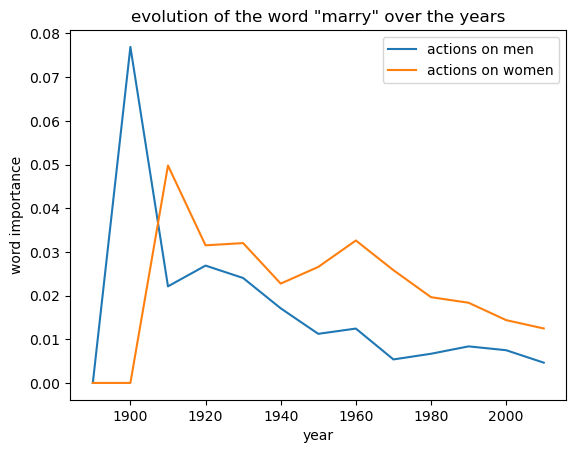

In [256]:
plot_word_evolution('marry', actions_on)

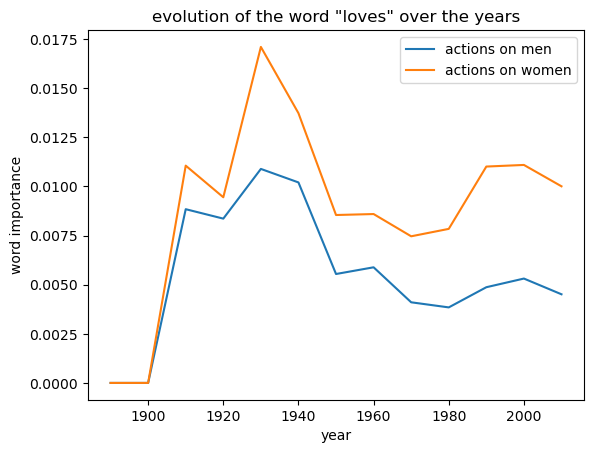

In [257]:
plot_word_evolution('loves', actions_on)

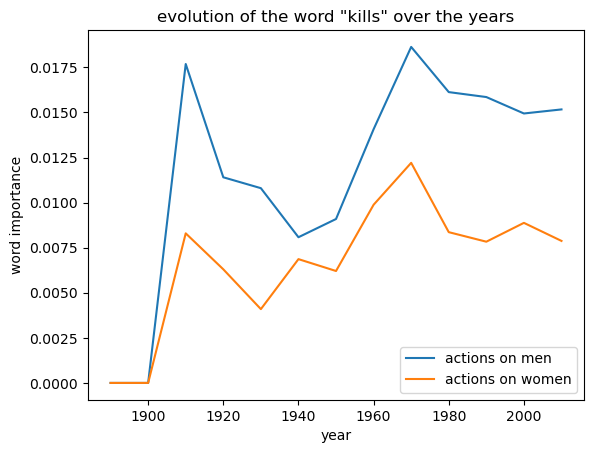

In [258]:
plot_word_evolution('kills', actions_on)

# Test

In [237]:
word = 'kills'
features = actions_on

In [238]:
def importance_word(x, word):
    return 0 if len(x) == 0 else x.count(word) / len(x)

In [239]:
res = movie_metadata_nlp[features].applymap(lambda x : importance_word(x, word))
res = movie_metadata_nlp[['decade_released']].merge(res, on='wikipedia_movie_id')
res = res.groupby('decade_released').agg(['mean', bootstrap_ci])
res = res.dropna()

In [240]:
res = res.reset_index()

In [241]:
res.columns = [' '.join(col).strip() for col in res.columns.values]

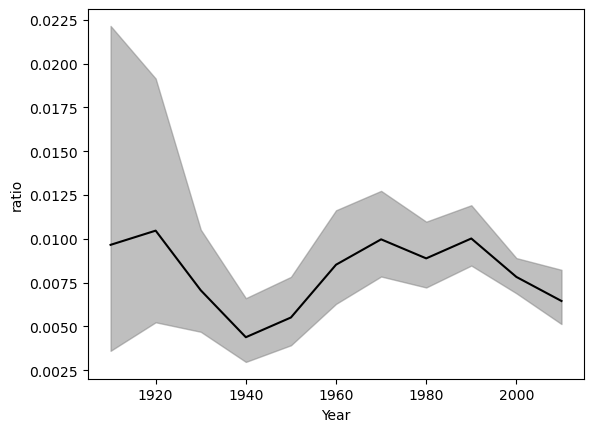

In [242]:
low_ci  = res['actions on men bootstrap_ci'].apply(lambda ci : ci[0])
high_ci = res['actions on men bootstrap_ci'].apply(lambda ci : ci[1])

plt.fill_between(res.decade_released, low_ci, high_ci, alpha = 0.5, color = 'gray')
plt.plot(res.decade_released, res['actions on men mean'], color = 'black')

plt.xlabel('Year')
plt.ylabel('ratio');

In [ ]:
plt.fill_between(stats_by_year.index, stats_by_year.average_worldwide_gross - stats_by_year.std_dev_worldwide_gross,
                 stats_by_year.average_worldwide_gross + stats_by_year.std_dev_worldwide_gross, alpha = 0.5, color = 'gray')
plt.plot(stats_by_year.average_worldwide_gross, color = 'black')

plt.xlabel('Year')
plt.ylabel('Worldwide gross revenue')

# Step 3

We need to analyze the plot summaries, we can use the coreNLP data given. This is a function to give a Element Tree on the coreNLP parsed plot of a given wikipedia movie id.